In [8]:
from racecar_utils import *
import pygeodesy

In [6]:
# Import ROS2 Types
abs_msg_list = absoluteFilePaths('novatel_oem7_msgs/msg')
add_types = {}

for pathstr in abs_msg_list:
    msgpath = Path(pathstr)
    msgdef = msgpath.read_text(encoding='utf-8')
    add_types.update(get_types_from_msg(msgdef, guess_msgtype(msgpath)))

register_types(add_types)
from rosbags.typesys.types import novatel_oem7_msgs__msg__BESTPOS as BESTPOS
from rosbags.typesys.types import novatel_oem7_msgs__msg__BESTVEL as BESTVEL
from rosbags.typesys.types import novatel_oem7_msgs__msg__Oem7Header as Oem7Header
from rosbags.typesys.types import nav_msgs__msg__Odometry as Odometry
from rosbags.typesys.types import geometry_msgs__msg__PoseWithCovariance as PoseWithCovariance
from rosbags.typesys.types import geometry_msgs__msg__TwistWithCovariance as TwistWithCovariance
from rosbags.typesys.types import geometry_msgs__msg__Pose as Pose
from rosbags.typesys.types import geometry_msgs__msg__Point as Point
from rosbags.typesys.types import geometry_msgs__msg__Quaternion as Quaternion
from rosbags.typesys.types import geometry_msgs__msg__Twist as Twist
from rosbags.typesys.types import geometry_msgs__msg__Vector3 as Vector3
from rosbags.typesys.types import sensor_msgs__msg__NavSatFix as NavSatFix

In [3]:
def nav2odom(gps_messages, track):

    deg2rad = math.pi/180.0

    local_odom_arr = []
    if track == 'ims':
        origin = (39.795398310617, -86.23476471193612, 223)
    elif track == 'lvms':
        origin = (36.272371177449344, -115.01030828834901, 594)
    gpsmap = pygeodesy.LocalCartesian(origin[0], origin[1], origin[2])

    prev_pos = [0.0,0.0,0.0]
    prev_time = gps_messages[0][0]-10000

    for ros_time, msg in tqdm(gps_messages):

        
        bestvel = None

        ros_time_vel = 0

        # Parse NavSatFix

        ros_header = msg.header
        ros_frame  = ros_header.frame_id
        lat        = msg.latitude
        lon        = msg.longitude
        hgt        = msg.altitude
        lat_stdev  = msg.position_covariance[0]
        lon_stdev  = msg.position_covariance[4] 
        hgt_stdev  = msg.position_covariance[8]

        # GPS 2 LOCAL CARTESIAN
        local_tuple = gpsmap.forward(lat, lon, hgt)
        heading = math.atan2(local_tuple[1] - prev_pos[1], local_tuple[0] - prev_pos[0])
        hor_speed = (((local_tuple[1] - prev_pos[1])**2+(local_tuple[0] - prev_pos[0])**2)**(0.5))/(ros_time-prev_time)
        
        trk_r  = R.from_euler('z',heading)
        quat = (trk_r).as_quat()
        rot_stdev = (math.pi/2*180)
        prev_pos[0] = local_tuple[0]
        prev_pos[1] = local_tuple[1]
        prev_pos[2] = local_tuple[2]
        prev_time   =  ros_time
        
        ros_header.frame_id = 'map'
        # Populate Odom Message
        gps_to_ramg : np.ndarray = np.eye(4)
        gps_to_ramg[0,3]=-1.606
        maptogps : np.ndarray             = np.eye(4)
        maptogps[0:3,3]                   = np.asarray([local_tuple[0], local_tuple[1], local_tuple[2]])
        maptogps[0:3,0:3]                 = R.from_quat(np.asarray([quat[0], quat[1], quat[2], quat[3]])).as_matrix()
        ramg_pose : np.ndarray            = np.matmul(maptogps, gps_to_ramg)
        ramg_quat : np.ndarray            = R.from_matrix(ramg_pose[0:3,0:3]).as_quat()
        
        
        odom_point   = Point(x=ramg_pose[0,3],y=ramg_pose[1,3],z=ramg_pose[2,3])
        odom_quat    = Quaternion(x=ramg_quat[0],y=ramg_quat[1],z=ramg_quat[2],w=ramg_quat[3])
        linear_vel   = Vector3(x=hor_speed,y=0.0,z=0.0)
        angular_vel  = Vector3(x=0.0,y=0.0,z=0.0)
        odom_pose    = Pose(position=odom_point,orientation=odom_quat)
        odom_twist   = Twist(linear=linear_vel,angular=angular_vel)
        cov_pose     = np.zeros(36)
        cov_pose[0]  = lon_stdev*lon_stdev
        cov_pose[7]  = lat_stdev*lat_stdev
        cov_pose[14] = hgt_stdev*hgt_stdev
        cov_pose[21] = rot_stdev*rot_stdev
        cov_pose[28] = rot_stdev*rot_stdev
        cov_pose[35] = rot_stdev*rot_stdev
        cov_twist    = np.zeros(36)
        cov_twist[0] = .125*.125
        cov_twist[7] = .0025
        cov_twist[14]= .0025
        odom_posec   = PoseWithCovariance(pose=odom_pose,covariance=cov_pose)
        odom_twistc  = TwistWithCovariance(twist=odom_twist,covariance=cov_twist)
        
        local_odom = Odometry(header = ros_header,
                              child_frame_id = 'rear_axle_middle_ground',
                              pose = odom_posec,
                              twist= odom_twistc)

        local_odom_arr.append([ros_time, local_odom])

    return local_odom_arr  

In [5]:
# EURORACING
euro_bag_file = '/p/cavalier/data/RAW_ROSBAG/EuroRacing/LVMS/LVMS-MULTI-SLOW with TUM/20220104_LVMS_run2_multi_tum'
topics = ['novatel_btm_id0_gps']
topic_types = ['sensor_msgs/msg/NavSatFix']
gps_messages = []

# create reader instance and open for reading
with Reader(euro_bag_file) as reader:

    # messages() accepts connection filters
    connections = [x for x in reader.connections if x.topic in topics]
    for connection, timestamp, rawdata in tqdm(reader.messages(connections=connections)):
        msg = deserialize_cdr(rawdata, connection.msgtype)
        if connection.msgtype == 'sensor_msgs/msg/NavSatFix':
            gps_messages.append((timestamp,msg))

euro_odom = nav2odom(gps_messages,'lvms')
start_time = 1641321300.0
end_time = 1641322600.0
pruned_euro_odom = [euro_odom[i] for i, y in enumerate(euro_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]

write_solo_bag(ego_bag_file=euro_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/EURORACING/LVMS/MULTI-SLOW-TUM-NO-ANNO',
                 ego_namespace='vehicle_6',
                 ego_odom=pruned_euro_odom,
                 start_time=start_time,
                 end_time=end_time)

40468it [00:01, 21572.21it/s]
100%|██████████| 40468/40468 [00:09<00:00, 4092.01it/s]
1078972it [33:21, 538.97it/s] 


NameError: name 'Odometry' is not defined

In [5]:
#MULTI-SLOW-MIT-KAIST

mit_bag_file = '../../data/RAW_ROSBAG/MIT-PITT-RW/LVMS/LVMS-MULTI-SLOW with KAIST/LVMS-MULTI-SLOW with KAIST'
kaist_bag_file = '../../data/RAW_ROSBAG/KAIST/LVMS/LVMS-MULTI-SLOW with MIT-PITT-RW/sensors_2022-01-02_14-20-08'
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']

mit_gps_messages, mit_vel_messages = read_bag_file(mit_bag_file, topics)
kaist_gps_messages, kaist_vel_messages = read_bag_file(kaist_bag_file, topics)

mit_local_odom = gen_local_odom(mit_gps_messages, mit_vel_messages,'lvms')
kaist_local_odom = gen_local_odom(kaist_gps_messages, kaist_vel_messages,'lvms')

# start_time = 1641163600.0
# end_time = 1641164300.0
# pruned_mit_odom = [mit_local_odom[i] for i, y in enumerate(mit_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]
# pruned_kaist_odom = [kaist_local_odom[i] for i, y in enumerate(kaist_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]

# write_merged_bag(ego_bag_file=mit_bag_file, 
#                  target_bag = '../../data/LOCAL_ODOM/MIT-PITT-RW/LVMS/MULTI-SLOW-KAIST-GPS',
#                  ego_namespace='vehicle_8',
#                  obj_namespace='vehicle_4',
#                  ego_odom=pruned_mit_odom,
#                  obj_odom=pruned_kaist_odom,
#                  start_time=start_time,
#                  end_time=end_time)

# write_merged_bag(ego_bag_file=kaist_bag_file, 
#                  target_bag = '../../data/LOCAL_ODOM/KAIST/LVMS/MULTI-SLOW-MIT-PITT-RW-GPS',
#                  ego_namespace='vehicle_4',
#                  obj_namespace='vehicle_8',
#                  ego_odom=pruned_kaist_odom,
#                  obj_odom=pruned_mit_odom,
#                  start_time=start_time,
#                  end_time=end_time)

54616it [10:45, 84.57it/s] 
47367it [07:07, 110.83it/s]
  0%|          | 0/27309 [00:00<?, ?it/s]


NameError: name 'Point' is not defined

In [ ]:
# TUM SOLO-FAST-140-170
tum_bag_file = '../../data/RAW_ROSBAG/TUM/LVMS/LVMS-FAST-140-170/perception_bag_202201072129'
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']

tum_gps_messages, tum_vel_messages = read_bag_file(tum_bag_file, topics)
tum_local_odom = gen_local_odom(tum_gps_messages, tum_vel_messages)

start_time = 1641587975.0
end_time = 1641588600.0
pruned_tum_odom = [tum_local_odom[i] for i, y in enumerate(tum_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]

write_solo_bag(ego_bag_file=tum_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/TUM/LVMS/SOLO-FAST-140-170',
                 ego_namespace='vehicle_3',
                 ego_odom=pruned_tum_odom,
                 start_time=start_time,
                 end_time=end_time)

In [ ]:
# Polimove SOLO-SLOW-70
poli_bag_file = '../../data/RAW_ROSBAG/PoliMove/LVMS/LVMS-SLOW-70/20211228_lvms_solo_slow_polimove'
topics = ['/novatel_top/bestgnsspos', '/novatel_top/bestvel']

poli_gps_messages, poli_vel_messages = read_bag_file(poli_bag_file, topics)
poli_local_odom = gen_local_odom(poli_gps_messages, poli_vel_messages)

start_time = 0.0
end_time = 2641588600.0
# pruned_tum_odom = [tum_local_odom[i] for i, y in enumerate(tum_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]

write_solo_bag(ego_bag_file=poli_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/PoliMove/LVMS/SOLO-SLOW-70',
                 ego_namespace='vehicle_5',
                 ego_odom=poli_local_odom,
                 start_time=start_time,
                 end_time=end_time)

In [ ]:
#MIT LVMS-SLOW-70

mit_bag_file = '../../data/RAW_ROSBAG/MIT-PITT-RW/LVMS/LVMS-SLOW-70/LVMS-SLOW-70'
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']

mit_gps_messages, mit_vel_messages = read_bag_file(mit_bag_file, topics)

mit_local_odom = gen_local_odom(mit_gps_messages, mit_vel_messages)

write_solo_bag(ego_bag_file=mit_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/MIT-PITT-RW/LVMS/SOLO-SLOW-70',
                 ego_namespace='vehicle_8',
                 ego_odom=mit_local_odom,
                 start_time=start_time,
                 end_time=end_time)

43716it [11:51, 61.40it/s] 


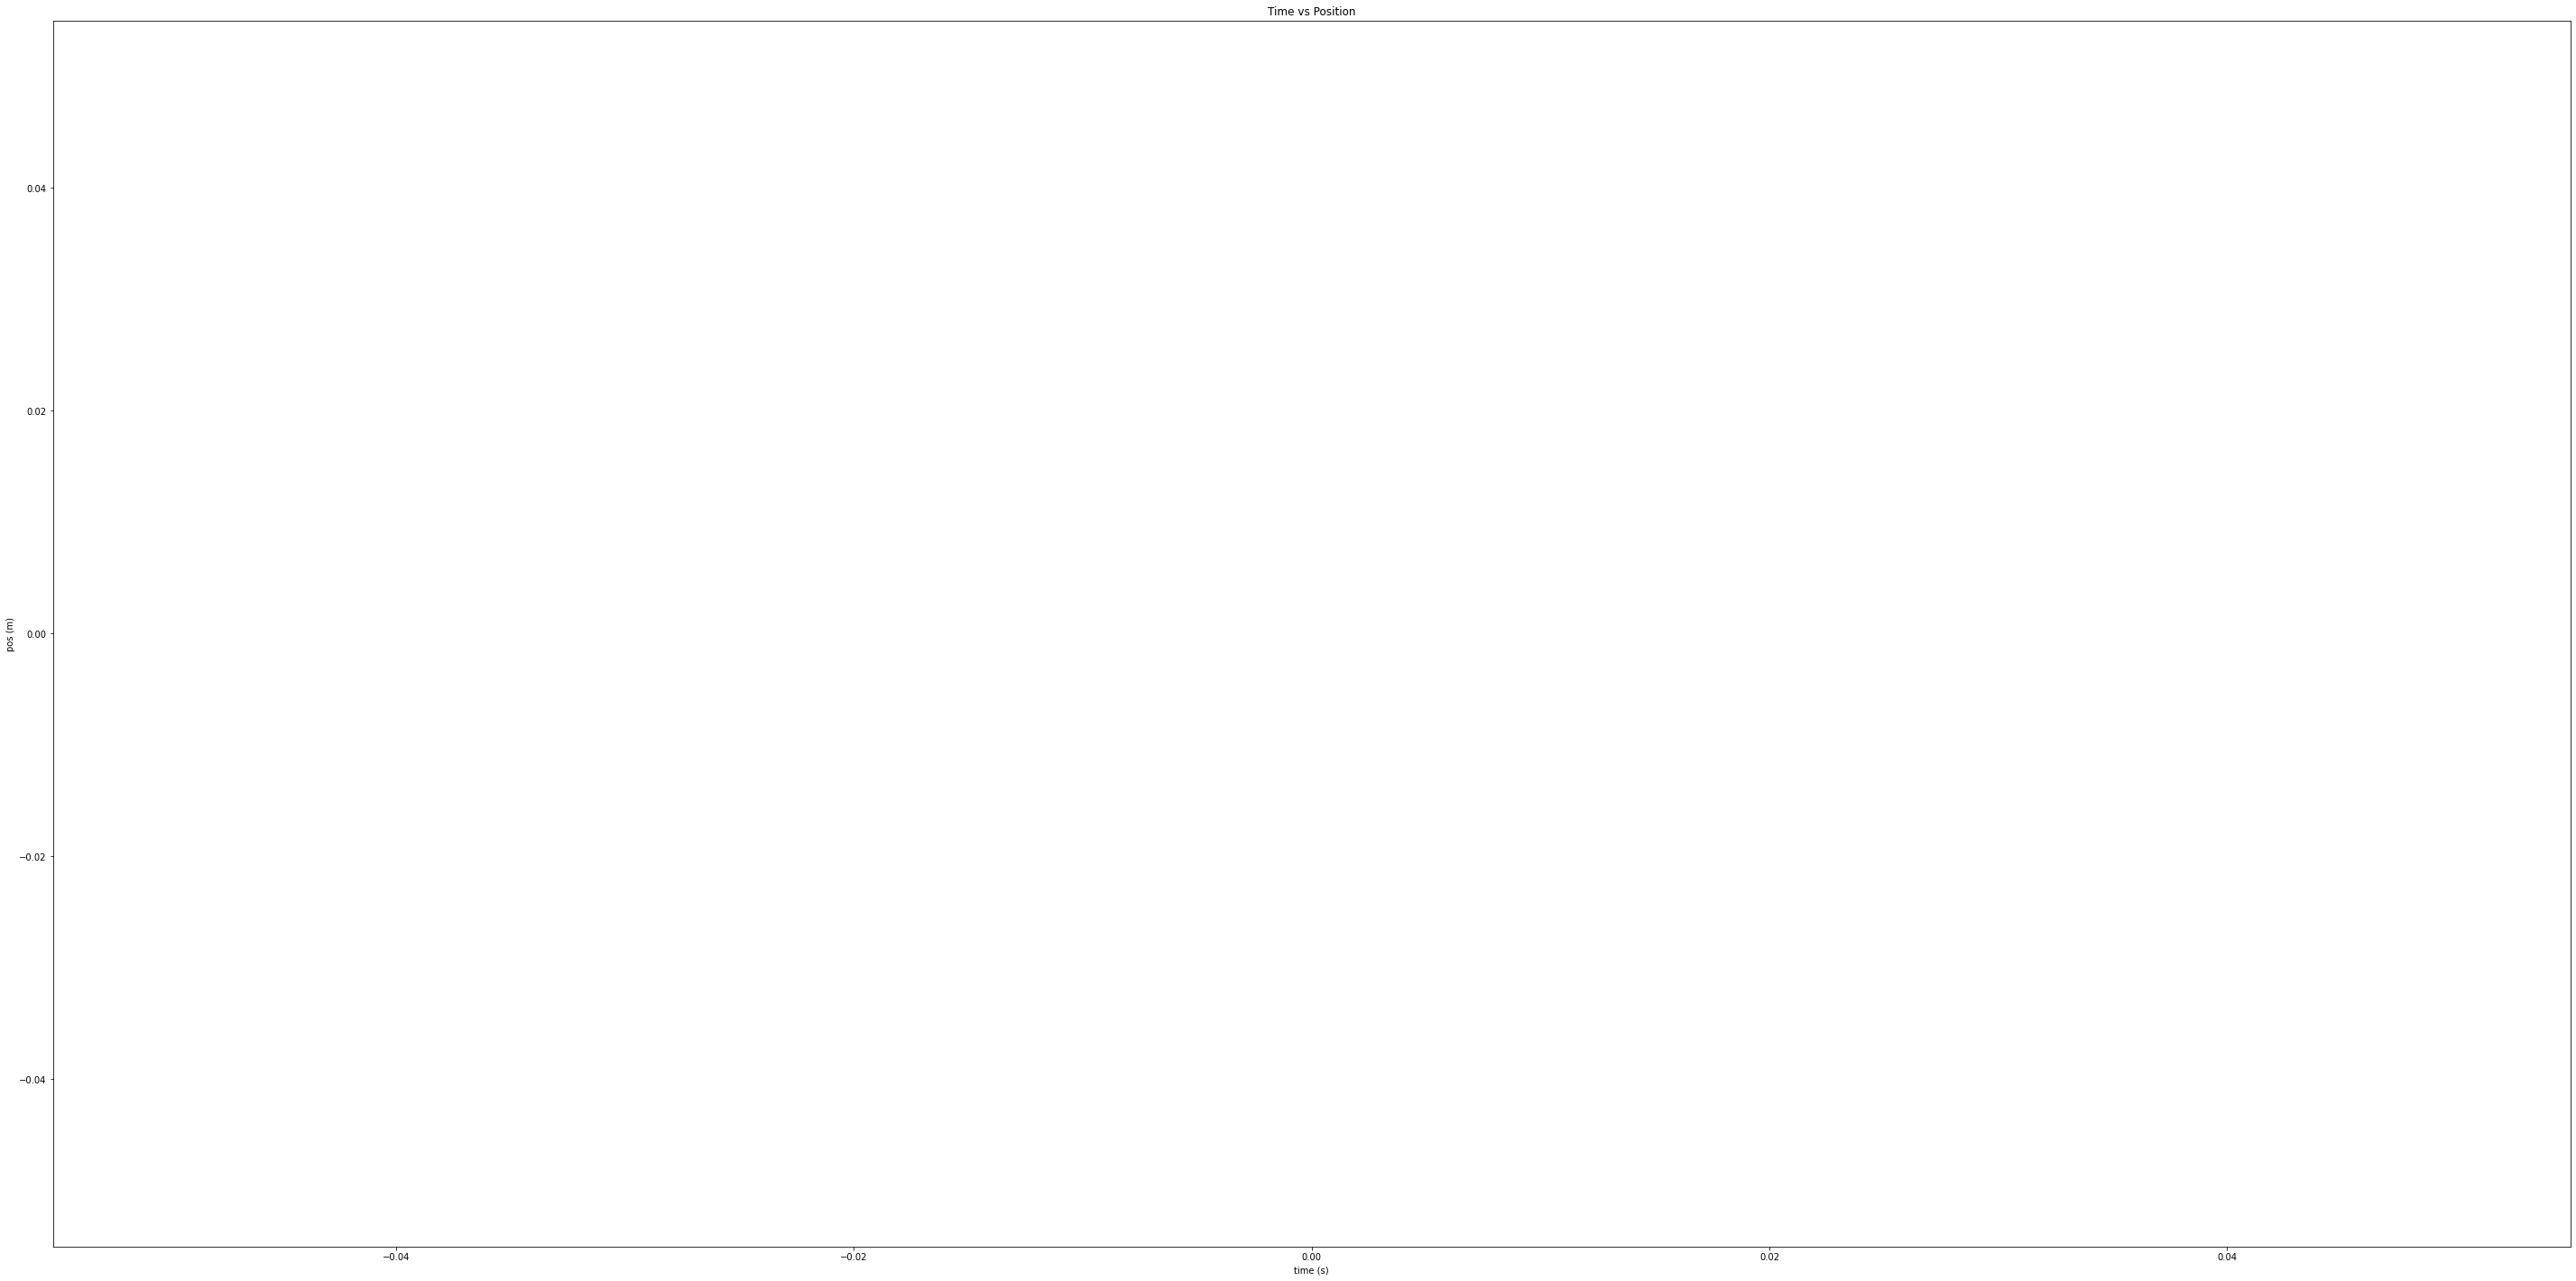

In [18]:
cav_bag_file = '../../data/RAW_ROSBAG/EURORACING/LVMS/LVMS-FAST-100-140/20211229_LVMS_run1_single_iac_dataset'
topics = ['/novatel_btm_id0_gps']
topic_types = ['sensor_msgs/msg/NavSatFix']
cav_gps_messages, cav_vel_messages = read_bag_file(cav_bag_file, topics,topic_types)
cx_pos = []
cy_pos = []
ctime  = []
for odom in cav_gps_messages:
    cx_pos.append(odom[1].lat)
    cy_pos.append(odom[1].lon)
    ctime.append(odom[0]*1e-9)

plt.rcParams['figure.figsize'] = [50,25]

fig, ax = plt.subplots(1, 1)
ax.plot(ctime, cx_pos, marker='o',color='r',linestyle='-', markersize = 1)
# ax.plot(ctime, cy_pos, marker='o',color='r',linestyle='-', markersize = 1)
# plt.gca().set_aspect('equal', adjustable = 'box')
plt.title('Time vs Position')
plt.xlabel('time (s)')
plt.ylabel('pos (m)')
plt.show()


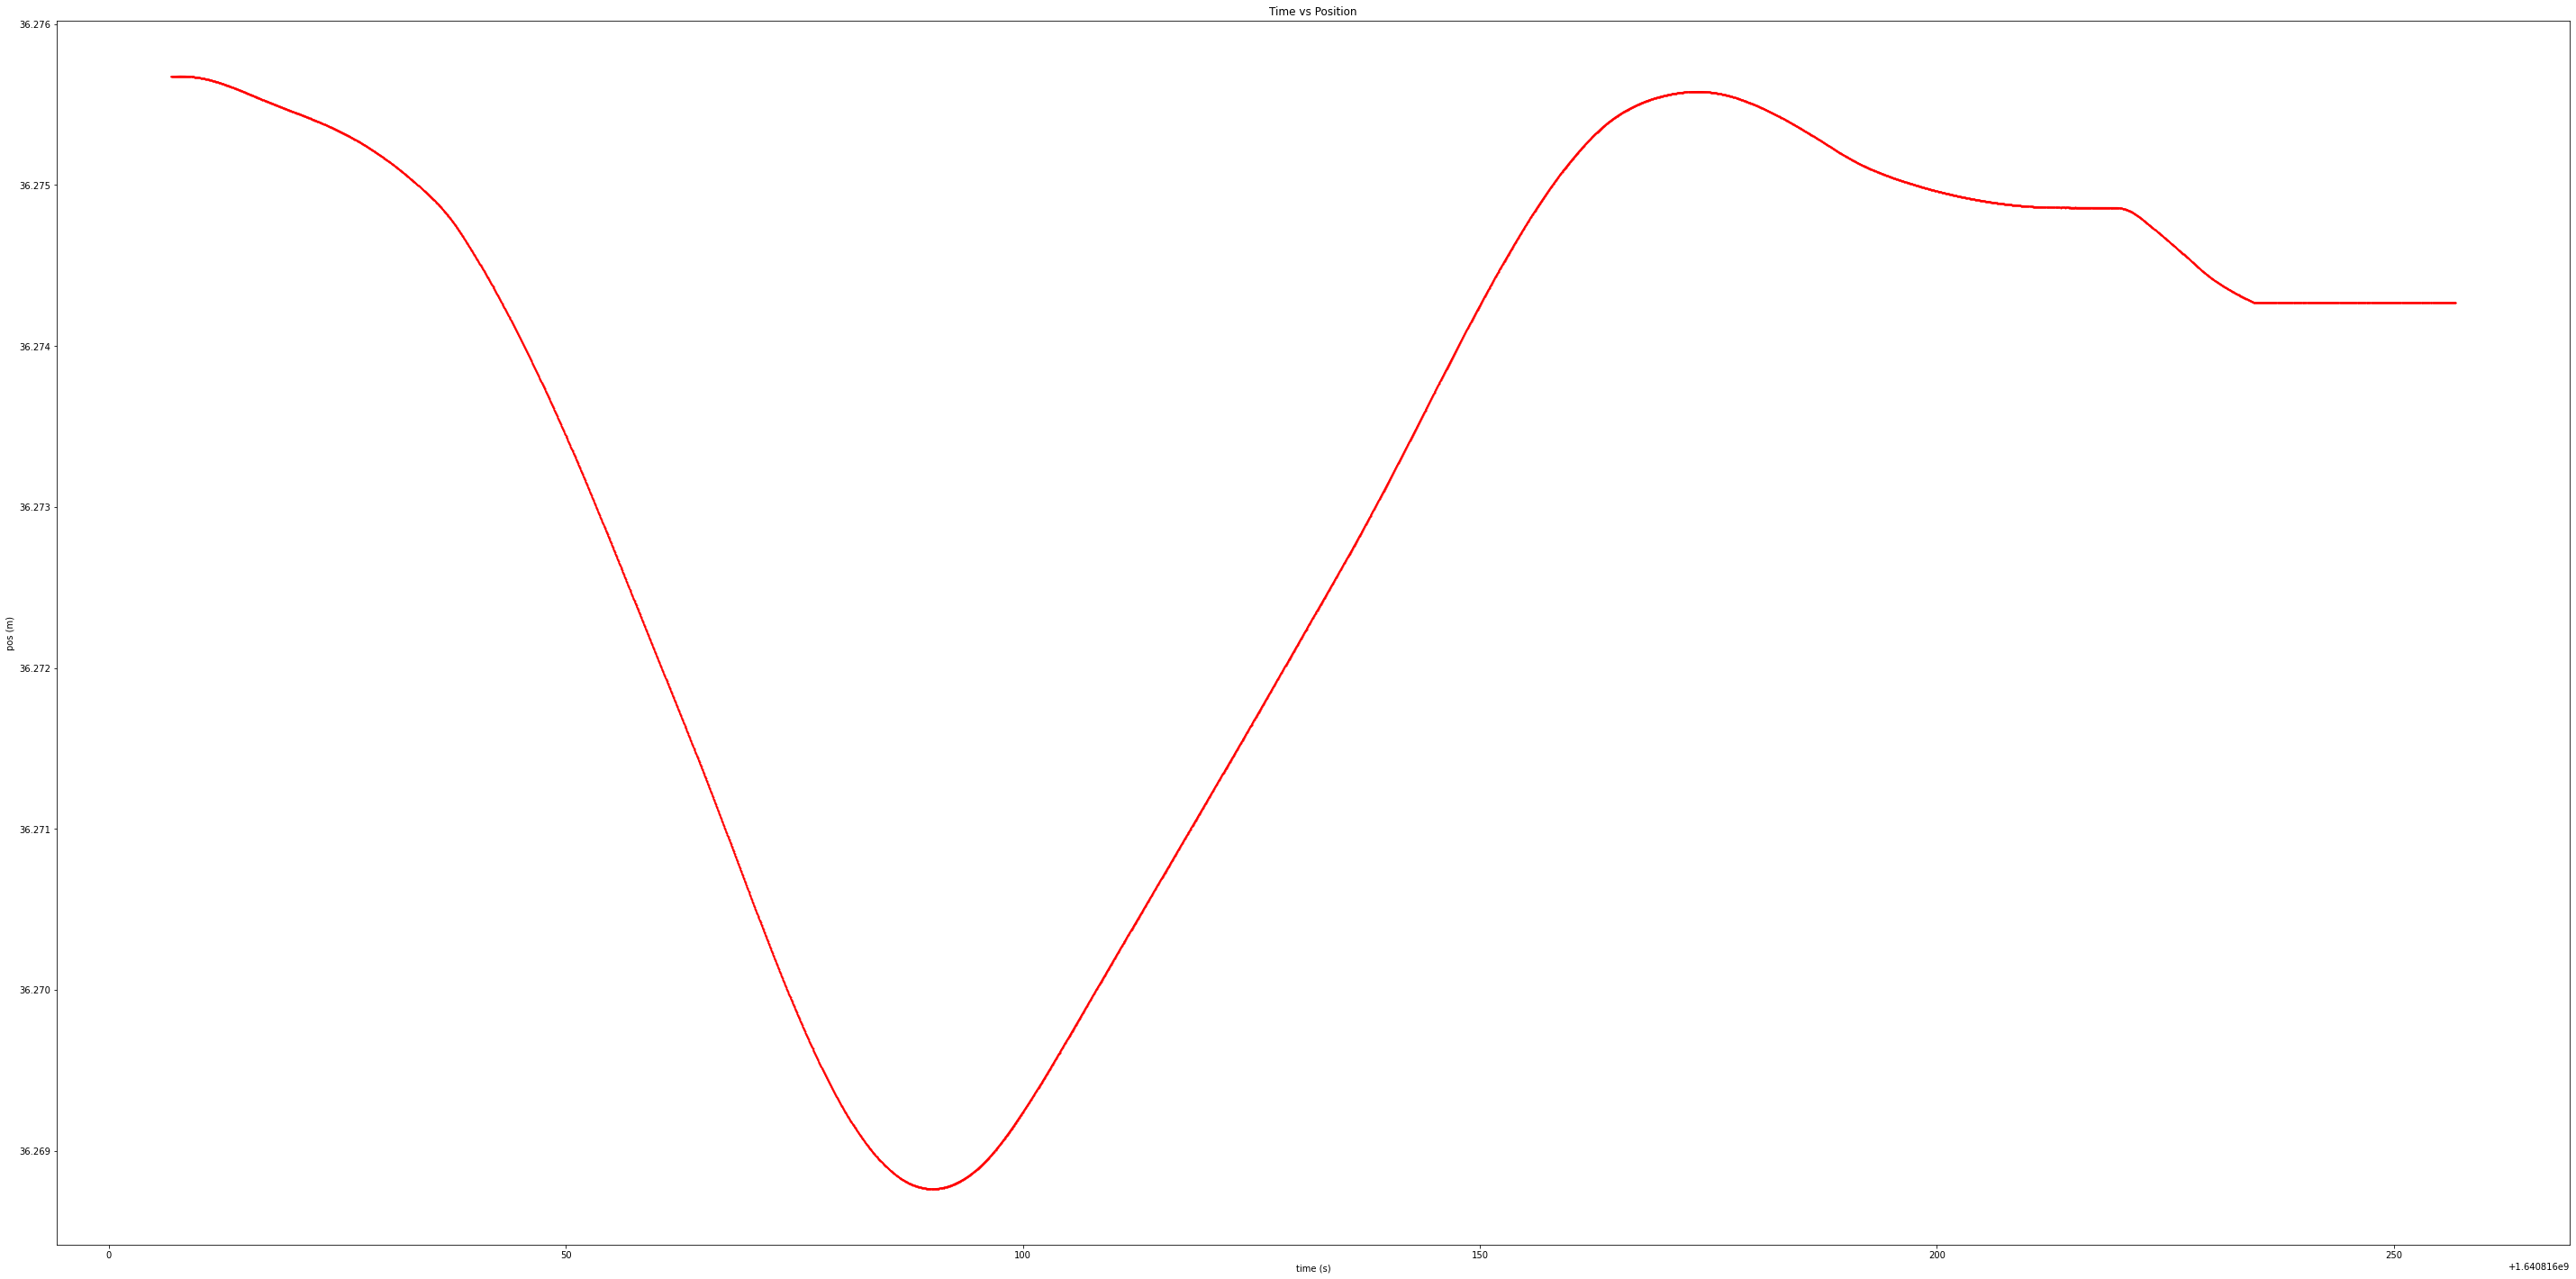

In [17]:
plt.rcParams['figure.figsize'] = [50,25]

fig, ax = plt.subplots(1, 1)
ax.plot(ctime[-5000:], cx_pos[-5000:], marker='o',color='r',linestyle='-', markersize = 1)
# ax.plot(ctime, cy_pos, marker='o',color='r',linestyle='-', markersize = 1)
# plt.gca().set_aspect('equal', adjustable = 'box')
plt.title('Time vs Position')
plt.xlabel('time (s)')
plt.ylabel('pos (m)')
plt.show()


In [ ]:

cav_bag_file = '../../data/RAW_ROSBAG/Cavalier/cavalier/rosbag2_2022_01_04-17_06_21'
poli_bag_file = '../../data/RAW_ROSBAG/PoliMove/LVMS/LVMS-MULTI-SLOW with Cavalier/20220104_lvms_multi_polimove_01_OK'
poli_topics = ['/novatel_top/bestgnsspos', '/novatel_top/bestvel']
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']

cav_gps_messages, cav_vel_messages = read_bag_file(cav_bag_file, topics)
poli_gps_messages, poli_vel_messages = read_bag_file(poli_bag_file, poli_topics)

cav_local_odom = gen_local_odom(cav_gps_messages, cav_vel_messages, 'lvms')
poli_local_odom = gen_local_odom(poli_gps_messages, poli_vel_messages, 'lvms')

cx_pos = []
cy_pos = []
px_pos = []
py_pos = []
ctime  = []
ptime  = []
for odom in cav_local_odom:
    cx_pos.append(odom[1].pose.pose.position.x)
    cy_pos.append(odom[1].pose.pose.position.y)
    ctime.append(odom[0]*1e-9)
for odom in poli_local_odom:
    px_pos.append(odom[1].pose.pose.position.x)
    py_pos.append(odom[1].pose.pose.position.y)
    ptime.append(odom[0]*1e-9)

plt.rcParams['figure.figsize'] = [50,25]

fig, ax = plt.subplots(1, 1)
ax.plot(ctime, cx_pos, marker='o',color='r',linestyle='-', markersize = 1)
ax.plot(ctime, cy_pos, marker='o',color='r',linestyle='-', markersize = 1)

ax.plot(ptime, px_pos, marker='o',color='g',linestyle='-', markersize = 1)
ax.plot(ptime, py_pos, marker='o',color='g',linestyle='-', markersize = 1)
plt.gca().set_aspect('equal', adjustable = 'box')
plt.title('Time vs Position')
plt.xlabel('time (s)')
plt.ylabel('pos (m)')
plt.show()

start_time = 1641334200.0
end_time = 1641334800.0
pruned_cav_odom = [cav_local_odom[i] for i, y in enumerate(cav_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]
pruned_poli_odom = [poli_local_odom[i] for i, y in enumerate(poli_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]

write_merged_bag(ego_bag_file=cav_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/CAVALIER/LVMS/MULTI-SLOW-POLI-GPS',
                 ego_namespace='vehicle_9',
                 obj_namespace='vehicle_5',
                 ego_odom=pruned_cav_odom,
                 obj_odom=pruned_poli_odom,
                 start_time=start_time,
                 end_time=end_time)

write_merged_bag(ego_bag_file=poli_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/POLIMOVE/LVMS/MULTI-SLOW-CAV-GPS',
                 ego_namespace='vehicle_5',
                 obj_namespace='vehicle_9',
                 ego_odom=pruned_poli_odom,
                 obj_odom=pruned_cav_odom,
                 start_time=start_time,
                 end_time=end_time)

In [ ]:
#KAIST IMS-PYLON 

kaist_bag_file = '../../data/RAW_ROSBAG/KAIST/IMS/IMS-PYLON/sensors_2021-10-23_13-17-49-full'
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']

kaist_gps_messages, kaist_vel_messages = read_bag_file(kaist_bag_file, topics)

kaist_local_odom = gen_local_odom(kaist_gps_messages, kaist_vel_messages, 'ims')

write_solo_bag(ego_bag_file=kaist_bag_file, 
                 target_bag = '../../data/LOCAL_ODOM/KAIST/IMS/SOLO-PYLON',
                 ego_namespace='vehicle_4',
                 ego_odom=kaist_local_odom,
                 start_time=0.0,
                 end_time=1635013000.0)


In [9]:
# TUM IMS-PYLON

tum_bag_file = '../../data/RAW_ROSBAG/TUM/IMS/IMS-FAST-100-140/perception_bag_202110231933'
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']
topic_types = ['novatel_oem7_msgs/msg/BESTPOS','novatel_oem7_msgs/msg/BESTVEL']


tum_gps_messages, tum_vel_messages = read_bag_file(tum_bag_file, topics, topic_types)

tum_local_odom = gen_local_odom(tum_gps_messages, tum_vel_messages, 'ims')

start_time = 0.0
end_time = 1641599200.0
pruned_tum_odom = [tum_local_odom[i] for i, y in enumerate(tum_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]
cx_pos = []
cy_pos = []
ctime  = []
ptime  = []
for odom in pruned_tum_odom:
    cx_pos.append(odom[1].pose.pose.position.x)
    cy_pos.append(odom[1].pose.pose.position.y)
    ctime.append(odom[0]*1e-9)

plt.rcParams['figure.figsize'] = [50,25]

fig, ax = plt.subplots(1, 1)
ax.plot(ctime, cx_pos, marker='o',color='r',linestyle='-', markersize = 1)
ax.plot(ctime, cy_pos, marker='o',color='r',linestyle='-', markersize = 1)

plt.gca().set_aspect('equal', adjustable = 'box')
plt.title('Time vs Position')
plt.xlabel('time (s)')
plt.ylabel('pos (m)')
plt.show()

# write_solo_bag(ego_bag_file=kaist_bag_file, 
#                  target_bag = '../../data/LOCAL_ODOM/KAIST/IMS/SOLO-PYLON',
#                  ego_namespace='vehicle_4',
#                  ego_odom=kaist_local_odom,
#                  start_time=0.0,
#                  end_time=1635013000.0)


48350it [00:02, 21109.22it/s]
  0%|                                                 | 0/24175 [00:00<?, ?it/s]


NameError: name 'Point' is not defined

In [ ]:
tum_bag_file = '../../data/RAW_ROSBAG/TUM/LVMS/LVMS-MULTI-FAST with Polimove/perception_bag_202201080026'
poli_bag_file = '../../data/RAW_ROSBAG/PoliMove/LVMS/LVMS-MULTI-FAST with TUM/20220107_lvms_multi_polimove_gps_only'
poli_topics = ['/novatel_top/bestgnsspos', '/novatel_top/bestvel']
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']

tum_gps_messages, tum_vel_messages = read_bag_file(tum_bag_file, topics)
poli_gps_messages, poli_vel_messages = read_bag_file(poli_bag_file, poli_topics)

tum_local_odom = gen_local_odom(tum_gps_messages, tum_vel_messages, 'lvms')
poli_local_odom = gen_local_odom(poli_gps_messages, poli_vel_messages, 'lvms')

start_time = 1641598400.0
end_time = 1641599200.0
pruned_tum_odom = [cav_local_odom[i] for i, y in enumerate(tum_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]
pruned_poli_odom = [poli_local_odom[i] for i, y in enumerate(poli_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]
cx_pos = []
cy_pos = []
px_pos = []
py_pos = []
ctime  = []
ptime  = []
for odom in pruned_tum_odom:
    cx_pos.append(odom[1].pose.pose.position.x)
    cy_pos.append(odom[1].pose.pose.position.y)
    ctime.append(odom[0]*1e-9)
for odom in pruned_poli_odom:
    px_pos.append(odom[1].pose.pose.position.x)
    py_pos.append(odom[1].pose.pose.position.y)
    ptime.append(odom[0]*1e-9)

plt.rcParams['figure.figsize'] = [50,25]

fig, ax = plt.subplots(1, 1)
ax.plot(ctime, cx_pos, marker='o',color='r',linestyle='-', markersize = 1)
ax.plot(ctime, cy_pos, marker='o',color='r',linestyle='-', markersize = 1)

ax.plot(ptime, px_pos, marker='o',color='g',linestyle='-', markersize = 1)
ax.plot(ptime, py_pos, marker='o',color='g',linestyle='-', markersize = 1)
plt.gca().set_aspect('equal', adjustable = 'box')
plt.title('Time vs Position')
plt.xlabel('time (s)')
plt.ylabel('pos (m)')
plt.show()


# write_merged_bag(ego_bag_file=cav_bag_file, 
#                  target_bag = '../../data/LOCAL_ODOM/TUM/LVMS/MULTI-FAST-POLI-GPS',
#                  ego_namespace='vehicle_3',
#                  obj_namespace='vehicle_5',
#                  ego_odom=pruned_cav_odom,
#                  obj_odom=pruned_poli_odom,
#                  start_time=start_time,
#                  end_time=end_time)


In [ ]:
tum_bag_file = '../../data/RAW_ROSBAG/TUM/LVMS/LVMS-MULTI-FAST with Polimove/perception_bag_202201080026'
euro_bag_file = '../../data/RAW_ROSBAG/PoliMove/LVMS/LVMS-MULTI-FAST with TUM/20220107_lvms_multi_polimove_gps_only'
euro_topics = ['/novatel_top/bestgnsspos', '/novatel_top/bestvel']
topics = ['/novatel_top/bestpos', '/novatel_top/bestvel']

tum_gps_messages, tum_vel_messages = read_bag_file(tum_bag_file, topics)
poli_gps_messages, poli_vel_messages = read_bag_file(poli_bag_file, poli_topics)

tum_local_odom = gen_local_odom(tum_gps_messages, tum_vel_messages, 'lvms')
poli_local_odom = gen_local_odom(poli_gps_messages, poli_vel_messages, 'lvms')

start_time = 1641598400.0
end_time = 1641599200.0
pruned_tum_odom = [cav_local_odom[i] for i, y in enumerate(tum_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]
pruned_poli_odom = [poli_local_odom[i] for i, y in enumerate(poli_local_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]
cx_pos = []
cy_pos = []
px_pos = []
py_pos = []
ctime  = []
ptime  = []
for odom in pruned_tum_odom:
    cx_pos.append(odom[1].pose.pose.position.x)
    cy_pos.append(odom[1].pose.pose.position.y)
    ctime.append(odom[0]*1e-9)
for odom in pruned_poli_odom:
    px_pos.append(odom[1].pose.pose.position.x)
    py_pos.append(odom[1].pose.pose.position.y)
    ptime.append(odom[0]*1e-9)

plt.rcParams['figure.figsize'] = [50,25]

fig, ax = plt.subplots(1, 1)
ax.plot(ctime, cx_pos, marker='o',color='r',linestyle='-', markersize = 1)
ax.plot(ctime, cy_pos, marker='o',color='r',linestyle='-', markersize = 1)

ax.plot(ptime, px_pos, marker='o',color='g',linestyle='-', markersize = 1)
ax.plot(ptime, py_pos, marker='o',color='g',linestyle='-', markersize = 1)
plt.gca().set_aspect('equal', adjustable = 'box')
plt.title('Time vs Position')
plt.xlabel('time (s)')
plt.ylabel('pos (m)')
plt.show()


# write_merged_bag(ego_bag_file=cav_bag_file, 
#                  target_bag = '../../data/LOCAL_ODOM/TUM/LVMS/MULTI-FAST-POLI-GPS',
#                  ego_namespace='vehicle_3',
#                  obj_namespace='vehicle_5',
#                  ego_odom=pruned_cav_odom,
#                  obj_odom=pruned_poli_odom,
#                  start_time=start_time,
#                  end_time=end_time)